# Elo Category Recommendation

1. Loading packages
2. Exploratory analysis
 - 2.1. Missing data
 - 2.2. Time/date analysis + feature engineering
3. Feature selection
4. Modelling

# 1. Loading packages

We start by loading the main packages we will use on this analysis

In [1]:
# Import packages
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import lightgbm as lgb
import pickle
from tqdm import tqdm
from feature_selector import FeatureSelector
from myutils import *

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import sys
import timeit
import gc

#pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', 300)

In [2]:
# Load data into pandas dataframes
train_data = pd.read_csv('DSA_04/train.csv')
test_data = pd.read_csv('DSA_04/test.csv')
merchants = pd.read_csv('DSA_04/merchants.csv')
new_transactions = pd.read_csv('DSA_04/new_merchant_transactions.csv')
transactions = pd.read_csv('DSA_04/historical_transactions.csv')
sample_submission = pd.read_csv('DSA_04/sample_submission.csv')

# 2. Exploratory analysis

Let's preview our datasets to see how they look like

In [3]:
# Preview of train dataset
train_data.head(3).append(train_data.tail(3))

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
201914,2017-08,C_ID_7666735b3d,4,3,0,0.093494
201915,2016-07,C_ID_73f5a0efd0,3,2,1,-4.676589
201916,2017-07,C_ID_92c9984c58,3,1,1,-1.859413


In [4]:
# Preview of test dataset
test_data.head(3).append(test_data.tail(3))

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
123620,2016-09,C_ID_21d56d950c,5,1,1
123621,2017-06,C_ID_6c46fc5a9d,2,1,0
123622,2016-10,C_ID_87e7979a5f,5,1,1


In [5]:
# Preview of merchants dataset
merchants.head(3).append(merchants.tail(3))

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
334693,M_ID_f2045dd267,35,561,7,-0.057471,-0.057471,N,A,A,0.96,0.982957,3,0.90,0.924769,6,0.74,0.750763,8,Y,160,21,5.0
334694,M_ID_9139332ccc,35,511,7,-0.057471,-0.057471,Y,A,A,0.94,0.919558,3,0.82,0.783000,6,0.65,0.584000,12,Y,-1,-1,NaN
334695,M_ID_cd2c0b07e9,35,606,17,-0.057471,-0.057471,N,A,A,0.90,0.913902,3,0.73,0.744417,6,0.53,0.540334,10,Y,69,9,1.0


In [6]:
# Preview of new_transactions dataset
new_transactions.head(3).append(new_transactions.tail(3))

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
1963028,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16
1963030,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1.0,9,37


In [7]:
# Preview of transactions dataset
transactions.head(3).append(transactions.tail(3))

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
29112358,Y,C_ID_5c240d6e3c,3,N,0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,Y,C_ID_5c240d6e3c,331,N,0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9
29112360,Y,C_ID_5c240d6e3c,331,N,0,A,514,M_ID_1a75f94f92,-2,1.134411,2017-10-26 14:09:40,1.0,16,9


In [8]:
# Preview of sample_submission dataset
sample_submission.head(3).append(sample_submission.tail(3))

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
123620,C_ID_21d56d950c,0
123621,C_ID_6c46fc5a9d,0
123622,C_ID_87e7979a5f,0


What kind of data type our features have? Let's take a look!

In [9]:
# Obtaining general info about the dataset
train_data.info()
test_data.info()
merchants.info()
transactions.info()
new_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_grou

This provides with useful information. Some of the data that should be datetime are classified as objects. Also, when we look at the number of non-null registers we notice that it doesn't to the total number of entries, meaning we might have some missing values. 

Now we are going to investigate if we have missing data, and try to figure how to fix them, if possible.

In [10]:
check_missing(train_data)

Great! There are no missing values in this dataset.


No missing values at train_data! Great! Next is test_data

In [11]:
check_missing(test_data)

,Missing n,% Missing
first_active_month,1,0.000809
card_id,0,0.000000
feature_1,0,0.000000
feature_2,0,0.000000
feature_3,0,0.000000


There is one register with missing data on the test dataset. The card_id referenced is C_ID_c27b4f80f7 and shows up in the transactions dataset, where the earliest purchase date was on 2017-03. With this info we can fill up the missing data.

In [12]:
# Identifying which register has a missing value

test_data.loc[test_data['first_active_month'].isnull(),:]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaN,C_ID_c27b4f80f7,5,2,1


In [13]:
# Looking up for any purchases from C_ID_c27b4f80f7 card in the transactions/new_transactions dataset.

# new_transactions.loc[new_transactions['card_id'] == 'C_ID_c27b4f80f7', :] # No transactions were found in this dataset
transactions.loc[transactions['card_id'] == 'C_ID_c27b4f80f7', ['purchase_date']].sort_values(by = 'purchase_date', ascending = True).head(1)

,purchase_date
25672893,2017-03-09 01:34:22


So now we will set 'first_active_month' as '2017-03' for the card_id = 'C_ID_c27b4f80f7', and double check again for missing values

In [14]:
# Fill in the missing value of 'first_active_month'.
test_data.loc[test_data['first_active_month'].isnull(),'first_active_month'] = '2017-03'

check_missing(test_data)

Great! There are no missing values in this dataset.


What about merchants?

I'll save it for another time. Right now it isn't the focus and only if needed to improve the model I may come back to consider it later. 

Transactions?

There are 2 files for transactions. One containing historical data and another with transactions from new merchants.
I'm calling it transactions and new_transactions. Any missing data?

In [15]:
check_missing(new_transactions)

,Missing n,% Missing
category_2,111745,5.692473
category_3,55922,2.848758
merchant_id,26216,1.335486
authorized_flag,0,0.000000
card_id,0,0.000000


In [16]:
check_missing(transactions)

,Missing n,% Missing
category_2,2652864,9.112500
category_3,178159,0.611970
merchant_id,138481,0.475678
authorized_flag,0,0.000000
card_id,0,0.000000


We have missing data in both datasets, and we will fill those missing values with the mode.

In [17]:
for df in [new_transactions, transactions]:
    df['category_2'].fillna(1.0, inplace = True)
    df['category_3'].fillna('A', inplace = True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace = True)

# Checkpoint 1

In [18]:
dataframes = [train_data, test_data, transactions, new_transactions]
df_title = [title + '_v7_ckp1.pkl' for title in ['train_data', 'test_data', 'transactions', 'new_transactions']]

for df, title in zip(dataframes, df_title):
    with open( title, 'wb') as pkl_f:
        pickle.dump(df, pkl_f)

In [ ]:
with open( 'train_data_v7_ckp1.pkl', 'rb') as pkl_f:
    train_data = pickle.load(pkl_f)
with open( 'test_data_v7_ckp1.pkl', 'rb') as pkl_f:
    test_data = pickle.load(pkl_f)
with open( 'transactions_v7_ckp1.pkl', 'rb') as pkl_f:
    transactions = pickle.load(pkl_f)
with open( 'new_transactions_v7_ckp1.pkl', 'rb') as pkl_f:
    new_transactions = pickle.load(pkl_f)

In [19]:
print(new_transactions.shape) #1963031
print(transactions.shape) #29112361

(1963031, 14)
(29112361, 14)


Now that the missing data has been handled. Let'go explore other features

We should investigate better 'installments' to comprehend what 0, -1 and 999 means. 

In [20]:
new_transactions['installments'].value_counts(1)*100

 0      46.980613
 1      42.596271
-1       2.848758
 2       2.787984
 3       2.279638
 4       0.754700
 6       0.529233
 5       0.473553
 10      0.453330
 12      0.145184
 8       0.079214
 7       0.043963
 9       0.024350
 11      0.003107
 999     0.000102
Name: installments, dtype: float64

It seems -1 and 999 represent missing values. So let's replace the values in categorical features and in installments for NaN.

In [ ]:
# Let's fix the the values we've found as -1, 999 and set it to NaN -- later

#for col in ['city_id', 'state_id','subsector_id','merchant_category_id', 'installments'] :
#    new_transactions[col].replace(-1, np.nan, inplace = True)
#    transactions[col].replace(-1, np.nan, inplace = True)

In [21]:
check_missing(transactions,10)

Great! There are no missing values in this dataset.


target

Text(0.5,1,'Train: target without outliers')

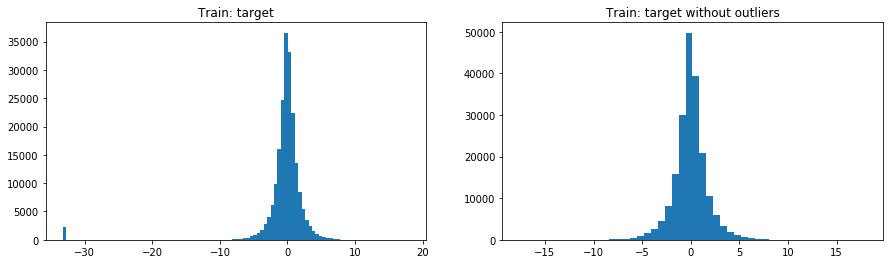

In [22]:
plt.figure(figsize = (15,4))

# Target
plt.subplot(121)
plt.hist(train_data['target'], bins = 100)
plt.title('Train: target')

# Target without outliers
plt.subplot(122)
plt.hist(train_data[train_data['target'] > train_data['target'].min()]['target'], bins = 50)
plt.title('Train: target without outliers')

In [23]:
replace_map = {'N':0, 'Y':1}

transactions['authorized_flag'].replace(replace_map, inplace = True)
new_transactions['authorized_flag'].replace(replace_map, inplace = True)

transactions['category_1'].replace(replace_map, inplace = True)
new_transactions['category_1'].replace(replace_map, inplace = True)

In [24]:
# Getting the mean of authorized transactions by card_id

auth_transactions = transactions.groupby(['card_id']).agg({'authorized_flag':'mean'})
auth_transactions.columns = ['auth_trans_mean']

# Splitting transactions dataset into 2. One with authorized transactions and other with denied ones

transactions_authorized = transactions[transactions['authorized_flag'] == 1]
transactions_denied = transactions[transactions['authorized_flag'] == 0]

Text(0.5,1,'Transactions: authorized purchases')

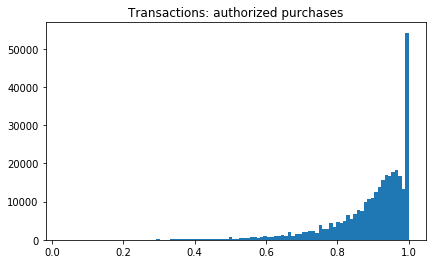

In [25]:
plt.figure(figsize = (15,4))

# Authorized transactions
plt.subplot(121)
plt.hist((auth_transactions['auth_trans_mean']), bins = 100)
plt.title('Transactions: authorized purchases')

In [26]:
def create_purchaseperinstallment(df):
    df['temp'] = df['installments'].replace([-1,999], np.nan)
    df['temp'] = df['temp'].replace(0, 1) ##
    df['parcel_value'] = (df['purchase_amount'] / df['temp'])
    del df['temp']

create_purchaseperinstallment(new_transactions)
create_purchaseperinstallment(transactions_authorized)
create_purchaseperinstallment(transactions_denied)

for df in [new_transactions, transactions_authorized, transactions_denied]:
    df['parcel_value'].fillna(0,  inplace = True)


Looking closer at dates/times..

'purchase_date' in new_transactions ranges from '2017-03-01' to '2018-04-30'

'purchase_date' in transactions ranges from '2017-01-01' to '2018-02-28'

'2018-05-01' will be set as a baseline for time

In [27]:
# Setting up a date as baseline for the analysis

baseline_date = '2018-05-01'
baseline_date = pd.to_datetime(baseline_date)

In [28]:
# Correct and create data types and add other related date/time features

def get_dates_info(df):
    col_name = 'purchase_date'
    
    df[col_name] = pd.to_datetime(df[col_name])
    df['period_day'] = df[col_name].dt.hour
    df['weekend'] = (df[col_name].dt.weekday >=5).astype(int)
    df['day'] = df[col_name].dt.day
    df['year'] = df[col_name].dt.year
    df['quarter'] = df[col_name].dt.quarter
    df['month'] = df[col_name].dt.month
    df['week'] = df[col_name].dt.week
    df['weekday'] = df[col_name].dt.weekday
    df['dayofyear'] = df[col_name].dt.dayofyear
    df['weekofyear'] = df[col_name].dt.weekofyear
    
    add_period_dates(df)
    add_holidays(df)
    
    temp1 = df['purchase_date'] - pd.to_timedelta(df['month_lag'], unit ='M')
    df['ref_date'] = pd.to_datetime(temp1.dt.year.astype(str) + '-' + temp1.dt.month.astype(str))
    df['purchase_date_age'] = (baseline_date - df['purchase_date']).dt.days
    df['month_diff'] = (baseline_date - df['ref_date']).dt.days//30
    df['prazo'] = (df['purchase_amount']*df['month_diff'])
    del df['ref_date']

def period_day(time_to_split):
    time_to_split = int(time_to_split)
    if time_to_split > 4 and time_to_split < 12:
        return 'morning'
    elif time_to_split >= 12 and time_to_split < 17:
        return 'afternoon'
    elif time_to_split >= 17 and time_to_split < 21:
        return 'evening'
    else:
        return 'night'

def period_month(date):
    if date < 10:
        period = 'beginning'
    elif date >= 10 and date < 25:
        period = 'middle'
    else:
        period = 'end'
    return period

def add_period_dates(df):
    df['period_day_cat'] = df['period_day'].apply(lambda x: period_day(x))
    df['period_month_cat'] = df['day'].apply(lambda x: period_month(x))

def add_holidays(df):
    
    df['natal_2017'] = (pd.to_datetime('2017-12-25') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)
    df['dia_maes_2017'] = (pd.to_datetime('2017-05-13') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)
    df['dia_pais_2017'] = (pd.to_datetime('2017-08-13') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)
    df['dia_criancas_2017'] = (pd.to_datetime('2017-10-12') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)
    df['dia_namorados_2017'] = (pd.to_datetime('2017-06-12') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)
    df['black_friday_2017'] = (pd.to_datetime('2017-11-24') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)
    df['dia_maes_2018'] = (pd.to_datetime('2018-05-13') - df['purchase_date']).dt.days.apply(lambda x: (1-x/37) if x > -7 and x < 30 else 0)

def interval(fun):
    def diff_interval_(x):
        if len(x)>2:
            diff = np.diff(x.sort_values()).astype(np.int64)*1e-9                
            return fun(diff)
        else:
            return np.nan
    diff_interval_.__name__ = 'interval_{}'.format(fun.__name__)
    return diff_interval_

In [29]:
start = timeit.default_timer()

get_dates_info(transactions_authorized)
get_dates_info(transactions_denied)
get_dates_info(new_transactions)

stop = timeit.default_timer()
show_elapsed_time(start, stop)

Total running time: 0h:2m:23s


In [30]:
train_data['first_active_month'] = pd.to_datetime(train_data['first_active_month'])
train_data['card_age'] = ((baseline_date - train_data['first_active_month']).dt.days)

test_data['first_active_month'] = pd.to_datetime(test_data['first_active_month'])
test_data['card_age'] = ((baseline_date - test_data['first_active_month']).dt.days)

In [31]:
aggs = {}

aggs['purchase_amount'] = ['mean','min','max','sum']
aggs['purchase_date'] = ['min','max']#,interval(np.mean), interval(np.min), interval(np.max), interval(np.std)]
#aggs['purchase_month'] = ['mean','min','max'] ##
aggs['month_lag'] = ['mean','min','max']
aggs['month_diff'] = ['mean','min','max']
aggs['prazo'] = ['mean']

In [32]:
new_column_names = get_new_columns('new_trans_cat',aggs)
file1 = new_transactions.groupby(['card_id','category_3']).agg(aggs)
file1.columns = new_column_names
file1.reset_index(drop = False, inplace = True)

new_column_names = get_new_columns('trans_auth_cat',aggs)
file2 = transactions_authorized.groupby(['card_id','category_3']).agg(aggs)
file2.columns = new_column_names
file2.reset_index(drop = False, inplace = True)

new_column_names = get_new_columns('trans_denied_cat',aggs)
file3 = transactions_denied.groupby(['card_id','category_3']).agg(aggs)
file3.columns = new_column_names
file3.reset_index(drop = False, inplace = True)

In [33]:
new_file1 = file1.columns.tolist()
new_file1.remove('category_3')
new_file1.remove('card_id')

new_file2 = file2.columns.tolist()
new_file2.remove('category_3')
new_file2.remove('card_id')

new_file3 = file3.columns.tolist()
new_file3.remove('category_3')
new_file3.remove('card_id')

In [34]:
def cols(val):
    coll = []
    for col in val:
        coll.append(str(col) + '_A')
        coll.append(str(col) + '_B')
        coll.append(str(col) + '_C')
    return coll

In [35]:
val = new_file1
file11 = file1.pivot(index = 'card_id' , columns = 'category_3' , values = val)
file11.columns = cols(val)
file11.reset_index(drop = False, inplace = True)

val = new_file2
file22 = file2.pivot(index = 'card_id' , columns = 'category_3' , values = val)
file22.columns = cols(val)
file22.reset_index(drop = False, inplace = True)

val = new_file3
file33 = file3.pivot(index = 'card_id' , columns = 'category_3' , values = val)
file33.columns = cols(val)
file33.reset_index(drop = False, inplace = True)

In [36]:
train_data = train_data.merge(file11, on = 'card_id', how = 'left')
train_data = train_data.merge(file22, on = 'card_id', how = 'left')
train_data = train_data.merge(file33, on = 'card_id', how = 'left')

test_data = test_data.merge(file11, on = 'card_id', how = 'left')
test_data = test_data.merge(file22, on = 'card_id', how = 'left')
test_data = test_data.merge(file33, on = 'card_id', how = 'left')

In [37]:
del new_file1, new_file2, new_file3,file1, file2, file3
del file11, file22,file33
gc.collect()

126

In [38]:
# I have generated a lot of NaN due to some transactions having happened only with certain categories, and not all of them.
for df in [train_data, test_data]:
    df.fillna(0, axis = 1, inplace = True)

In [39]:
new_transactions = pd.get_dummies(new_transactions, columns = ['period_day_cat', 'period_month_cat'])
transactions_authorized = pd.get_dummies(transactions_authorized, columns = ['period_day_cat', 'period_month_cat'])
transactions_denied = pd.get_dummies(transactions_denied, columns = ['period_day_cat', 'period_month_cat'])

In [40]:
aggs = {}

aggs['card_id'] = ['size']
aggs['subsector_id'] = ['nunique']
aggs['merchant_category_id'] = ['nunique']
aggs['merchant_id'] = ['nunique']
aggs['merchant_category_id'] = ['nunique']
aggs['day'] = ['nunique','mean','min']
aggs['year'] = ['nunique']
aggs['quarter'] = ['nunique']
aggs['month'] = ['nunique','mean','min','max','var']
aggs['week'] = ['nunique']
#aggs['dayofyear_pd'] = ['nunique']
#aggs['weekofyear_pd'] = ['nunique']
aggs['period_day'] = ['nunique']
aggs['weekend'] = ['nunique']# -- ['sum','mean']

aggs['period_day_cat_morning'] = ['mean']
aggs['period_day_cat_afternoon'] = ['mean']
aggs['period_day_cat_evening'] = ['mean']
aggs['period_day_cat_night'] = ['mean']
aggs['period_month_cat_beginning'] = ['mean']
aggs['period_month_cat_middle'] = ['mean']
aggs['period_month_cat_end'] = ['mean']

aggs['category_1'] = ['sum', 'mean'] 
aggs['purchase_amount'] = ['mean','min','max','sum','var']
aggs['installments'] = ['mean','min','max','sum','var'] #min remove
aggs['purchase_date'] = ['min','max']#,interval(np.mean), interval(np.min), interval(np.max), interval(np.std)]
#aggs['purchase_month'] = ['mean','min','max','std'] ##
aggs['month_lag'] = ['mean','min','max','var']
aggs['parcel_value'] = ['sum','mean','max','min','var']
aggs['month_diff'] = ['mean','min','max','var']
aggs['natal_2017'] = ['mean']
aggs['dia_maes_2017'] = ['mean']
aggs['dia_pais_2017'] = ['mean']
aggs['dia_criancas_2017'] = ['mean']
aggs['dia_namorados_2017'] = ['mean']
aggs['black_friday_2017'] = ['mean']
aggs['dia_maes_2018'] = ['mean']
aggs['prazo'] = ['mean','min','max','var']


In [41]:
new_column_names = get_new_columns('new_trans',aggs)
card_id_new_data = new_transactions.groupby('card_id').agg(aggs)
card_id_new_data.columns = new_column_names
card_id_new_data.reset_index(drop = False, inplace = True)

new_column_names = get_new_columns('hist_auth',aggs)
card_id_auth_trans = transactions_authorized.groupby('card_id').agg(aggs)
card_id_auth_trans.columns = new_column_names
card_id_auth_trans.reset_index(drop = False, inplace = True)

new_column_names = get_new_columns('hist_denied',aggs)
card_id_denied_trans = transactions_denied.groupby('card_id').agg(aggs)
card_id_denied_trans.columns = new_column_names
card_id_denied_trans.reset_index(drop = False, inplace = True)

In [42]:
def agg_categories(df):
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col+'_std'] = df.groupby([col])['purchase_amount'].transform('std')
        df[col+'_min'] = df.groupby([col])['purchase_amount'].transform('min')
        df[col+'_max'] = df.groupby([col])['purchase_amount'].transform('max')
        df[col+'_sum'] = df.groupby([col])['purchase_amount'].transform('sum')

    #Colunas float16 geram problemas no modelo
    #cols = [c for c,d in zip(df.columns, df.dtypes) if d == np.dtype('float16')]
    #df[cols] = df[cols].astype(np.float32)

In [43]:
agg_categories(new_transactions)
agg_categories(transactions_authorized)
agg_categories(transactions_denied)

In [44]:
def add_col_to_agg(df, pref):
    df[pref + '_purchase_date_diff'] = (df[pref + '_purchase_date_max'] - df[pref + '_purchase_date_min']).dt.days
    df[pref + '_purchase_date_average'] = df[pref + '_purchase_date_diff']/df[pref + '_card_id_size']
    df[pref + '_purchase_date_uptonow'] = (baseline_date - df[pref + '_purchase_date_max']).dt.days
    df[pref + '_purchase_date_uptomin'] = (baseline_date - df[pref + '_purchase_date_min']).dt.days

add_col_to_agg(card_id_new_data,'new_trans')
add_col_to_agg(card_id_auth_trans, 'hist_auth')
add_col_to_agg(card_id_denied_trans,'hist_denied')

In [45]:
for df in [card_id_new_data, card_id_auth_trans,card_id_denied_trans]:
    df.fillna(0, axis = 1, inplace = True)

In [46]:
print(train_data.shape)
print(test_data.shape)

(201917, 124)
(123623, 123)


In [47]:
train_data = train_data.merge(card_id_new_data, on = 'card_id', how = 'left')
train_data = train_data.merge(card_id_auth_trans, on = 'card_id', how = 'left')
train_data = train_data.merge(card_id_denied_trans, on = 'card_id', how = 'left')

test_data = test_data.merge(card_id_new_data, on = 'card_id', how = 'left')
test_data = test_data.merge(card_id_auth_trans, on = 'card_id', how = 'left')
test_data = test_data.merge(card_id_denied_trans, on = 'card_id', how = 'left')

In [51]:
print(train_data.shape)
print(test_data.shape)

(201917, 322)
(123623, 321)


In [52]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [53]:
final_group =  aggregate_per_month(transactions_authorized)
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [54]:
train_data = train_data.merge(final_group, on = 'card_id', how = 'left')
test_data = test_data.merge(final_group, on = 'card_id', how = 'left')

train_data = train_data.merge(additional_fields, on = 'card_id', how = 'left')
test_data = test_data.merge(additional_fields, on = 'card_id', how = 'left')

In [55]:
del final_group, additional_fields, transactions
gc.collect()

92

In [56]:
for df in [train_data,test_data]:
            df['purchase_amount_ratio_v1'] = df['new_trans_purchase_amount_sum']/df['hist_auth_purchase_amount_sum']
            df['purchase_amount_ratio_v2'] = df['new_trans_purchase_amount_mean']/df['hist_auth_purchase_amount_mean']
            df['purchase_amount_ratio_v3'] = df['new_trans_purchase_amount_min']/df['hist_auth_purchase_amount_min']
            df['purchase_amount_ratio_v4'] = df['new_trans_purchase_amount_max']/df['hist_auth_purchase_amount_sum']
            df['purchase_amount_ratio_v5'] = df['new_trans_purchase_amount_max']/df['hist_auth_purchase_amount_max']
            df['purchase_amount_diff_v1'] = df['new_trans_purchase_amount_sum']-df['hist_auth_purchase_amount_sum']
            df['purchase_amount_diff_v2'] = df['new_trans_purchase_amount_mean']-df['hist_auth_purchase_amount_mean']
            df['purchase_amount_diff_v3'] = df['new_trans_purchase_amount_max']-df['hist_auth_purchase_amount_max']
            df['purchase_amount_diff_v4'] = df['new_trans_purchase_amount_min']-df['hist_auth_purchase_amount_min']
            df['purchase_amount_diff_ratio_v1'] = df['purchase_amount_diff_v1']/df['hist_auth_purchase_amount_sum']
            df['purchase_amount_diff_ratio_v2'] = df['purchase_amount_diff_v2']/df['hist_auth_purchase_amount_sum']
            df['purchase_amount_diff_ratio_v3'] = df['purchase_amount_diff_v2']/df['purchase_amount_diff_v1']
            df['pa_mlag_ratio'] = df['new_trans_purchase_amount_sum']/(df['month_lag_mean'] - 1)
            df['pa_new_hist_ratio'] = df['new_trans_purchase_amount_sum']/(df['hist_auth_purchase_amount_sum'])
            df['pa_new_hist_mean_ratio'] = df['new_trans_purchase_amount_mean']/(df['hist_auth_purchase_amount_mean'])
            df['new_trans_first_buy'] = (df['new_trans_purchase_date_min'] - df['first_active_month']).dt.days
            df['hist_auth_first_buy'] = (df['hist_auth_purchase_date_min'] - df['first_active_month']).dt.days
            df['card_id_total'] = df['new_trans_card_id_size'] + df['hist_auth_card_id_size']
            df['card_id_ratio'] = df['new_trans_card_id_size'] / df['hist_auth_card_id_size']
            df['purchase_amount_total'] = df['new_trans_purchase_amount_sum'] + df['hist_auth_purchase_amount_sum']

In [57]:
for df in [train_data,test_data]:
    for f in ['hist_auth_purchase_date_max','hist_auth_purchase_date_min',
              'hist_denied_purchase_date_max','hist_denied_purchase_date_min',
              'new_trans_purchase_date_max','new_trans_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    for f in ['new_trans_cat_purchase_date_min_A','new_trans_cat_purchase_date_min_B',
              'new_trans_cat_purchase_date_min_C', 'new_trans_cat_purchase_date_max_A',
              'new_trans_cat_purchase_date_max_B', 'new_trans_cat_purchase_date_max_C',
              'trans_auth_cat_purchase_date_min_A','trans_auth_cat_purchase_date_min_B',
              'trans_auth_cat_purchase_date_min_C','trans_auth_cat_purchase_date_max_A',
              'trans_auth_cat_purchase_date_max_B','trans_auth_cat_purchase_date_max_C',
              'trans_denied_cat_purchase_date_min_A','trans_denied_cat_purchase_date_min_B',
              'trans_denied_cat_purchase_date_min_C','trans_denied_cat_purchase_date_max_A',
              'trans_denied_cat_purchase_date_max_B','trans_denied_cat_purchase_date_max_C']:
        df[f].replace(0,np.nan, inplace= True)
        df[f] = pd.to_datetime(df[f])
        df[f] = df[f].astype(np.int64) * 1e-9

In [58]:
def cos_dist_quantity(new_transactions,transactions_authorized):

    #generating vectors
    ht_vec = new_transactions.reset_index(drop=True).groupby(['card_id', 'merchant_category_id']
                                                   )['merchant_category_id'].size().unstack(fill_value=0)
    nt_vec = transactions_authorized.reset_index(drop=True).groupby(['card_id', 'merchant_category_id']
                                              )['merchant_category_id'].size().unstack(fill_value=0)
    print('vectors generated')

    #finding out missing merchant categories in vecs
    ht_miss_cat = np.setdiff1d(nt_vec.columns, ht_vec.columns)
    nt_miss_cat = np.setdiff1d(ht_vec.columns, nt_vec.columns)
    print('missing categories found')

    #fullfilling missing merchant categories
    for cat in ht_miss_cat:
        ht_vec[cat] = 0
    for cat in nt_miss_cat:
        nt_vec[cat] = 0
    print('missing categories fullfilled')

    #sorting columns
    cols_sorted = np.sort(ht_vec.columns)
    print('columns sorted')

    ht_vec = ht_vec[cols_sorted]
    nt_vec = nt_vec[cols_sorted]

    #renaming columns
    ht_vec.columns = ['ht_'+str(col) for col in cols_sorted]
    nt_vec.columns = ['nt_'+str(col) for col in cols_sorted]
    print('columns renamed')

    #merging vecs and fill NaNs with 0
    ht_nt_vec = pd.concat([ht_vec, nt_vec], axis=1, sort=False).fillna(0)
    print('vecs merged, NaNs filled')

    #estimating cosine distance
    dot_product = np.einsum('ij,ij->i', ht_nt_vec[ht_vec.columns], ht_nt_vec[nt_vec.columns])
    ht_vec_mod = (ht_nt_vec[ht_vec.columns] ** 2).sum(axis=1) ** (1/2)
    nt_vec_mod = (ht_nt_vec[nt_vec.columns] ** 2).sum(axis=1) ** (1/2)
    ht_nt_vec['cos_dist_count_by_merchant_category'] = 1 - dot_product / (ht_vec_mod * nt_vec_mod)
    print('cosine distance estimated')


    #train_test = train_test.merge(ht_nt_vec[['cos_dist_count_by_merchant_category']],
    #                              how='left', left_index=True, right_index=True)
    print('features added')
    return ht_nt_vec[['cos_dist_count_by_merchant_category']]

cos_dist_qt = cos_dist_quantity(new_transactions,transactions_authorized)


vectors generated
missing categories found
missing categories fullfilled
columns sorted
columns renamed
vecs merged, NaNs filled
cosine distance estimated
features added


In [59]:
cos_dist_qt['card_id'] = cos_dist_qt.index
cos_dist_qt.head()
train_data.shape

(201917, 384)

In [60]:
train_data = train_data.merge(cos_dist_qt, on = 'card_id', how = 'left')
test_data = test_data.merge(cos_dist_qt, on = 'card_id', how = 'left')

In [61]:
def cos_dist_purchase_amount(new_transactions,transactions_authorized):
    
    #generating vectors
    ht_vec = transactions_authorized.reset_index(drop=True).groupby(['card_id', 'merchant_category_id']
                                                   )['purchase_amount'].sum().unstack(fill_value=0)
    nt_vec = new_transactions.reset_index(drop=True).groupby(['card_id', 'merchant_category_id']
                                              )['purchase_amount'].sum().unstack(fill_value=0)
    print('vectors generated')
    
    #clearing memory
    #del ht_auth, nt
    #gc.collect()

    #finding out missing merchant categories in vecs
    ht_miss_cat = np.setdiff1d(nt_vec.columns, ht_vec.columns)
    nt_miss_cat = np.setdiff1d(ht_vec.columns, nt_vec.columns)
    print('missing categories found')

    #fullfilling missing merchant categories
    for cat in ht_miss_cat:
        ht_vec[cat] = 0
    for cat in nt_miss_cat:
        nt_vec[cat] = 0
    print('missing categories fullfilled')

    #sorting columns
    cols_sorted = np.sort(ht_vec.columns)
    print('columns sorted')

    ht_vec = ht_vec[cols_sorted]
    nt_vec = nt_vec[cols_sorted]

    #renaming columns
    ht_vec.columns = ['ht_'+str(col) for col in cols_sorted]
    nt_vec.columns = ['nt_'+str(col) for col in cols_sorted]
    print('columns renamed')

    #merging vecs and fill NaNs with 0
    ht_nt_vec = pd.concat([ht_vec, nt_vec], axis=1, sort=False).fillna(0)
    print('vecs merged, NaNs filled')
    
    #estimating cosine distance
    dot_product = np.einsum('ij,ij->i', ht_nt_vec[ht_vec.columns], ht_nt_vec[nt_vec.columns])
    ht_vec_mod = (ht_nt_vec[ht_vec.columns] ** 2).sum(axis=1) ** (1/2)
    nt_vec_mod = (ht_nt_vec[nt_vec.columns] ** 2).sum(axis=1) ** (1/2)
    ht_nt_vec['cos_dist_sum_by_merchant_category'] = 1 - dot_product / (ht_vec_mod * nt_vec_mod)
    print('cosine distance estimated')
    
    #adding created feature to train_test
    #with open(os.path.join(PATH_TO_DATA, 'train_test.pkl'), 'rb') as pkl_f:
    #    train_test = pickle.load(pkl_f)
    #print('train_test opened')

    #train_test = train_test.merge(ht_nt_vec[['cos_dist_sum_by_merchant_category']],
    #                              how='left', left_index=True, right_index=True)
    print('features added')
    
    return ht_nt_vec[['cos_dist_sum_by_merchant_category']]


cos_dist_pa = cos_dist_purchase_amount(new_transactions,transactions_authorized)
cos_dist_pa['card_id'] = cos_dist_pa.index
train_data = train_data.merge(cos_dist_pa, on = 'card_id', how = 'left')
test_data = test_data.merge(cos_dist_pa, on = 'card_id', how = 'left')

vectors generated
missing categories found
missing categories fullfilled
columns sorted
columns renamed
vecs merged, NaNs filled
cosine distance estimated
features added


In [62]:
print(train_data.shape)
print(test_data.shape)

(201917, 386)
(123623, 385)


In [63]:
check_missing(train_data)

,Missing n,% Missing
category_1_purchase_amount_std,177210,87.763784
category_1_installments_std,177210,87.763784
installments_purchase_amount_std,147475,73.037436
city_id_purchase_amount_std,91969,45.547923
hist_denied_period_day_cat_afternoon_mean,30959,15.332538


In [64]:
check_missing(test_data)

,Missing n,% Missing
category_1_purchase_amount_std,108570,87.823463
category_1_installments_std,108570,87.823463
installments_purchase_amount_std,90243,72.998552
city_id_purchase_amount_std,56450,45.663024
hist_denied_period_day_cat_afternoon_mean,18880,15.272239


In [65]:
for df in [train_data, test_data]:
    df.fillna(0, inplace = True)

In [66]:
del auth_transactions, transactions_authorized, transactions_denied, new_transactions, merchants, cos_dist_qt
gc.collect()

70

In [67]:
train_data['outliers'] = 0
test_data['outliers'] = 0
train_data.loc[train_data['target'] < -30, 'outliers'] = 1

for features in ['feature_1','feature_2','feature_3']:
    order_label = train_data.groupby([features])['outliers'].mean()
    train_data[features] = train_data[features].map(order_label)
    test_data[features] =  test_data[features].map(order_label)

feature_1
1    0.008058
2    0.010610
3    0.010479
4    0.010712
5    0.013145
Name: outliers, dtype: float64
feature_2
1    0.011385
2    0.008752
3    0.014166
Name: outliers, dtype: float64
feature_3
0    0.010283
1    0.011428
Name: outliers, dtype: float64


In [68]:
start = timeit.default_timer()

duplicateColumnNames = getDuplicateColumns(train_data)

stop = timeit.default_timer()
show_elapsed_time(start,stop)

print('Duplicate Columns are as follows')
for col in duplicateColumnNames:
    print('Column name : ', col)

Total running time: 0h:8m:21s
Duplicate Columns are as follows
Column name :  installments_count_mean
Column name :  installments_count_std
Column name :  pa_new_hist_mean_ratio
Column name :  pa_new_hist_ratio


In [69]:
# Delete duplicate columns
start = timeit.default_timer()

train_data.drop(columns = duplicateColumnNames, axis = 1, inplace = True)
test_data.drop(columns = duplicateColumnNames, axis = 1, inplace = True)

stop = timeit.default_timer()
show_elapsed_time(start,stop)

Total running time: 0h:0m:0s


# Checkpoint 2

In [70]:
dataframes = [train_data, test_data]
df_title = [title + '_v7_ckp2.pkl' for title in ['train_data', 'test_data']]

for df, title in zip(dataframes, df_title):
    with open( title, 'wb') as pkl_f:
        pickle.dump(df, pkl_f)

In [ ]:
import pickle
with open( 'train_data_v7_ckp2.pkl', 'rb') as pkl_f:
    train_data = pickle.load(pkl_f)
with open( 'test_data_v7_ckp2.pkl', 'rb') as pkl_f:
    test_data = pickle.load(pkl_f)

# 3. Feature selection

In [71]:
fs = FeatureSelector(data = train_data, labels = train_data['target'])

In [72]:
fs.identify_missing(missing_threshold=0.5)
missing_features = fs.ops['missing']

0 features with greater than 0.50 missing values.



In [73]:
#fs.identify_single_unique()
fs.identify_collinear(correlation_threshold=0.95)

99 features with a correlation magnitude greater than 0.95.



In [74]:
correlated_features = fs.ops['collinear']

In [75]:
all_to_remove = fs.check_removal()

Total of 99 features identified for removal


In [76]:
train_removed = fs.remove(methods = ['missing','collinear'])

Removed 99 features.


In [77]:
train_data = train_removed.copy()
feat = [c for c in train_data.columns if c not in ['target']]
test_data = test_data[feat]
print(train_data.shape)
print(test_data.shape)

(201917, 284)
(123623, 283)


In [78]:
from scipy.stats import ks_2samp
from tqdm import tqdm
list_p_value =[]

test_data_numeric = test_data.select_dtypes('number')
train_data_numeric = train_data.select_dtypes('number')
del train_data_numeric['target']

for i in tqdm(train_data_numeric.columns):
    list_p_value.append(ks_2samp(test_data_numeric[i] , train_data_numeric[i])[1])

Se = pd.Series(list_p_value, index = train_data_numeric.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

100%|██████████| 281/281 [00:07<00:00, 35.83it/s]


In [79]:
len(list_discarded)
list_discarded

['outliers',
 'new_trans_prazo_mean',
 'new_trans_parcel_value_mean',
 'new_trans_purchase_amount_mean',
 'installments_purchase_amount_max',
 'hist_auth_period_day_cat_evening_mean',
 'purchase_amount_mean_std',
 'city_id_purchase_amount_max',
 'new_trans_parcel_value_max',
 'trans_denied_cat_purchase_date_min_B',
 'installments_purchase_amount_mean',
 'new_trans_purchase_amount_sum']

In [80]:
for df in [train_data, test_data]:
    df.drop(list_discarded, axis = 1, inplace = True)

Data Normalization

In [81]:
print(train_data.shape)
print(test_data.shape)

(201917, 272)
(123623, 271)


In [82]:
for df in [train_data, test_data]:
    df.fillna(0, inplace = True)

In [83]:
from sklearn.preprocessing import StandardScaler,Normalizer,FunctionTransformer,QuantileTransformer,RobustScaler,PowerTransformer

scaler_x = StandardScaler()
scaler_y = StandardScaler()

rscaler_x = RobustScaler()
rscaler_y = RobustScaler()

jtrans_x = PowerTransformer(method='yeo-johnson')
jtrans_y = PowerTransformer(method='yeo-johnson')

boxcox_x = PowerTransformer(method='box-cox')
boxcox_y = PowerTransformer(method='box-cox')

qt_x = QuantileTransformer(output_distribution='normal')
qt_y = QuantileTransformer(output_distribution='normal')



temp_X_train = train_data.copy()
temp_X_test = test_data.copy()

temp_y_train = np.array(train_data['target']).reshape(-1, 1)


select = [c for c in temp_X_train.columns if c not in ['card_id', 'first_active_month','target']]  
temp_X_train_partial = temp_X_train[select]
temp_X_test_partial = temp_X_test[select]


df_normalized = pd.DataFrame(rscaler_x.fit_transform(temp_X_train_partial))
#df_transformed = pd.DataFrame(jtrans_x.fit_transform(df_normalized))
df_normalized.columns = select
temp_X_train[select] = df_normalized

df_normalized = pd.DataFrame(rscaler_x.transform(temp_X_test_partial))
#df_transformed = pd.DataFrame(jtrans_x.transform(df_normalized))
df_normalized.columns = select
temp_X_test[select] = df_normalized

df_to = pd.DataFrame(rscaler_y.fit_transform(temp_y_train))

In [84]:
train_data = temp_X_train.copy()
train_data['target'] = df_to
test_data = temp_X_test.copy()

In [85]:
check_missing(train_data)

Great! There are no missing values in this dataset.


In [86]:
for df in [train_data, test_data]:
    df.fillna(0, inplace = True)

# Model

In [87]:
features = [c for c in train_data.columns if c not in ['card_id', 'first_active_month','target']]
target = train_data['target']
sub_df = pd.DataFrame({"card_id":test_data["card_id"]})

In [88]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [89]:
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedKFold
from sklearn.metrics import mean_squared_error
import time

folds = KFold(n_splits=5, shuffle=True, random_state=4190)
oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))
start = timeit.default_timer()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, target.values)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][features],
                           label=target.iloc[trn_idx]
                          )
    val_data = lgb.Dataset(train_data.iloc[val_idx][features],
                           label=target.iloc[val_idx]
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(train_data.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_data[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
stop = timeit.default_timer()
show_elapsed_time(start,stop)

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.26268	valid_1's rmse: 2.23279
[200]	training's rmse: 2.2166	valid_1's rmse: 2.20756
[300]	training's rmse: 2.18673	valid_1's rmse: 2.19633
[400]	training's rmse: 2.16507	valid_1's rmse: 2.19115
[500]	training's rmse: 2.14821	valid_1's rmse: 2.18842
[600]	training's rmse: 2.13523	valid_1's rmse: 2.18687
[700]	training's rmse: 2.12439	valid_1's rmse: 2.18587
[800]	training's rmse: 2.11462	valid_1's rmse: 2.18523
[900]	training's rmse: 2.10557	valid_1's rmse: 2.1849
[1000]	training's rmse: 2.0974	valid_1's rmse: 2.18441
[1100]	training's rmse: 2.08983	valid_1's rmse: 2.18413
[1200]	training's rmse: 2.08217	valid_1's rmse: 2.18411
Early stopping, best iteration is:
[1117]	training's rmse: 2.08841	valid_1's rmse: 2.18404
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.24213	valid_1's rmse: 2.3188
[200]	training's rmse: 2.19672	valid_1's rmse: 2.29005


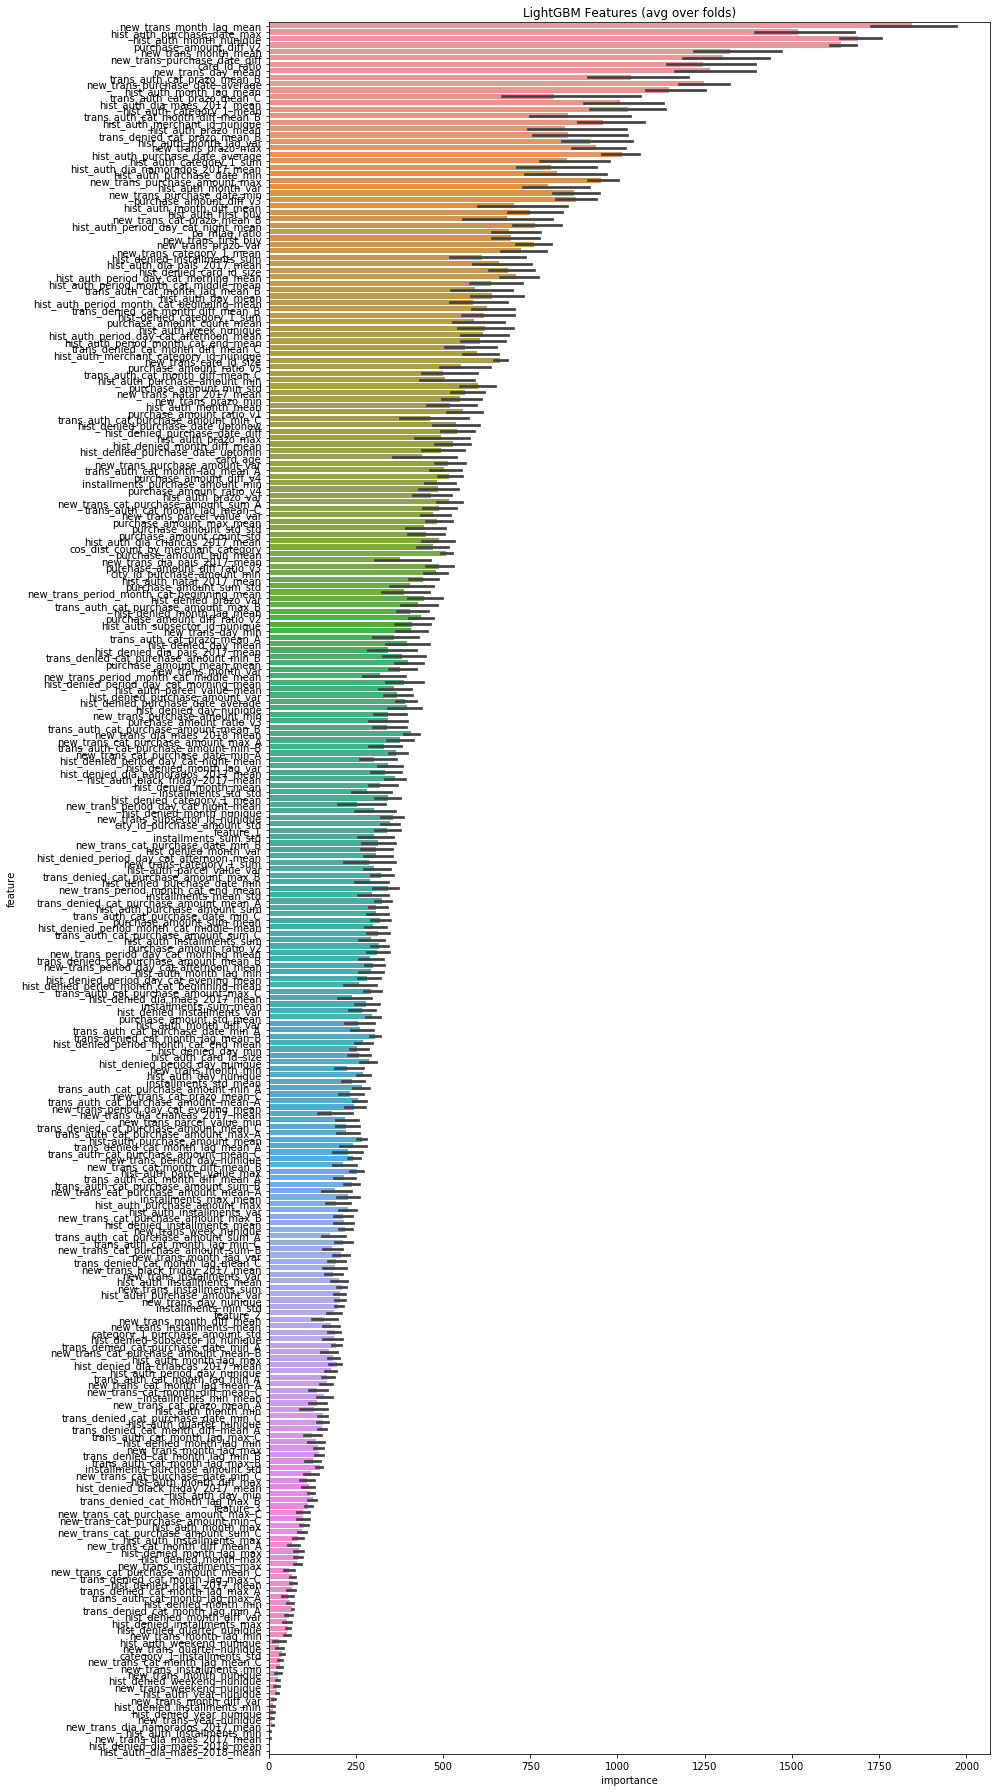

In [90]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
stop = timeit.default_timer()



In [91]:
predictions_reg_lgb = np.array(predictions).reshape(-1,1)
test_data_y_reg_lgb = pd.DataFrame(rscaler_y.inverse_transform(predictions_reg_lgb))
test_data_y_reg_lgb.column = 'target'

In [92]:
final_value = test_data_y_reg_lgb
final_value.describe()

,0
count,123623.000000
mean,-0.392881
std,1.171525
min,-16.028104
25%,-0.653686
50%,-0.187482
75%,0.169513
max,3.274026


In [93]:
sub_df = pd.DataFrame({"card_id":test_data["card_id"]}) 
sub_df['target'] = final_value
sub_df.to_csv("submission.csv", index = False)

Kaggle Private LB 0.61076 Public LB 0.60385

DSA Private LB 3.61379 Public LB 3.69612